In [ ]:
import os
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import email
import string
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
DOWNLOAD_HAM = ["https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2",
                "https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham_2.tar.bz2",
                "https://spamassassin.apache.org/old/publiccorpus/20030228_hard_ham.tar.bz2"]

DOWNLOAD_SPAM = ["https://spamassassin.apache.org/old/publiccorpus/20050311_spam_2.tar.bz2",
                 "https://spamassassin.apache.org/old/publiccorpus/20030228_spam.tar.bz2"]

In [ ]:
# Распаковка архива
folder_path = 'spamassassin_data'
files = os.listdir(folder_path)
print(files)

for file in files:
    tar = tarfile.open(folder_path + '/' + file, 'r:bz2')
    tar.extractall()
    tar.close()

['20030228_hard_ham.tar.bz2', '20030228_easy_ham_2.tar.bz2', '20050311_spam_2.tar.bz2', '20030228_spam.tar.bz2', '20030228_easy_ham.tar.bz2']


In [ ]:
easy_ham_path = 'easy_ham/'
easy_ham_2_path = 'easy_ham_2/'
hard_ham_path = 'hard_ham/'
spam_path = 'spam/'
spam_2_path = 'spam_2/'

def get_data(path):
    data = []
    files = os.listdir(path)
    for file in files:
        processed_file = open(path + file, encoding = 'ISO-8859-1')
        words_list = processed_file.read()
        data.append(words_list)
        processed_file.close()
    return data


easy_ham = get_data(easy_ham_path)
easy_ham_2 = get_data(easy_ham_2_path)
hard_ham = get_data(hard_ham_path)
spam = get_data(spam_path)
spam_2 = get_data(spam_2_path)

ham = easy_ham + easy_ham_2 + hard_ham
spam = spam + spam_2

np.random.shuffle(ham)
np.random.shuffle(spam)

In [ ]:
print(ham[5])

From fork-admin@xent.com  Wed Jul 24 04:47:42 2002
Return-Path: <fork-admin@xent.com>
Delivered-To: yyyy@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id E8F24440CD
	for <jm@localhost>; Tue, 23 Jul 2002 23:47:41 -0400 (EDT)
Received: from dogma.slashnull.org [212.17.35.15]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Wed, 24 Jul 2002 04:47:41 +0100 (IST)
Received: from xent.com ([64.161.22.236]) by dogma.slashnull.org
    (8.11.6/8.11.6) with ESMTP id g6O3kf418126 for <jm@jmason.org>;
    Wed, 24 Jul 2002 04:46:42 +0100
Received: from lair.xent.com (localhost [127.0.0.1]) by xent.com (Postfix)
    with ESMTP id AB8D0294137; Tue, 23 Jul 2002 20:32:05 -0700 (PDT)
Delivered-To: fork@spamassassin.taint.org
Received: from c007.snv.cp.net (h013.c007.snv.cp.net [209.228.33.241]) by
    xent.com (Postfix) with SMTP id 4E360294136 for <fork@xent.com>;
    Tue, 23 Jul 2002 20:31:27 -0700

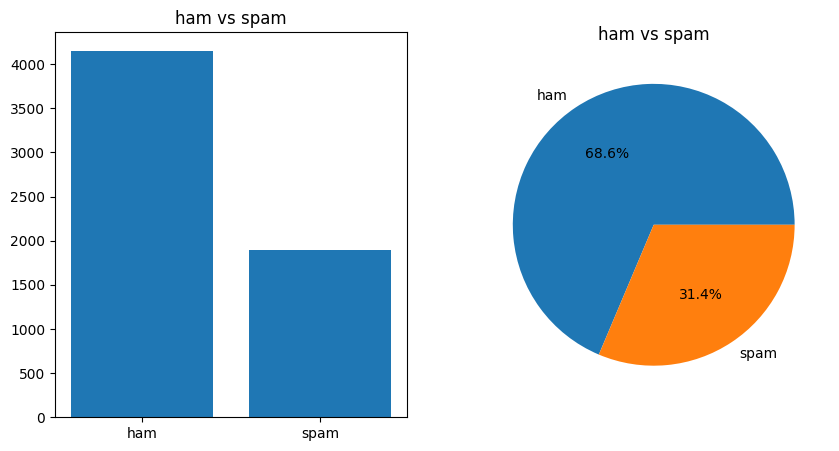

In [ ]:
count_ham = len(ham)
count_spam = len(spam)


plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.bar(['ham', 'spam'], [count_ham, count_spam])
plt.title('ham vs spam')

plt.subplot(1,2,2)
plt.pie([count_ham, count_spam], labels=['ham', 'spam'], autopct='%1.1f%%')
plt.title('ham vs spam')
plt.show()

In [ ]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def data_preprocessing(emails):
    cleaned_text_emails = []
    for mail in emails:
        email_text = email.message_from_string(mail) # convert the string to an email message object
        body = ''

        if email_text.is_multipart():
            for part in email_text.walk():
                ctype = part.get_content_type() # content type (/ "image" / "audio" / "video" / "application" / "text/plain" / "application/pdf")
                cdispo = str(part.get('Content-Disposition'))
                # skip any text/plain (txt) attachments
                if ctype == 'text/plain' and 'attachment' not in cdispo:
                    body = part.get_payload(decode=True) # get body of email
                    break
            # not multipart - i.e. plain text, no attachments
        else:
            body = email_text.get_payload(decode=True) # get body of email

        soup = BeautifulSoup(body, "html.parser") # get text from body (HTML/text)
        text = soup.get_text().lower()

        text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
        text = ''.join([i for i in text if not i.isdigit()]) # remove digits
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        stop_words = set(stopwords.words(['english', 'chinese']))
        words_list = [w for w in text.split() if w not in stop_words] # remove stop words
        words_list = [lemmatizer.lemmatize(w) for w in words_list] # lemmatization
        words_list = [stemmer.stem(w) for w in words_list] # stemming
        cleaned_text_emails.append(' '.join(words_list))
    return cleaned_text_emails

In [ ]:
cleaned_ham = data_preprocessing(ham)
cleaned_spam = data_preprocessing(spam)

In [ ]:
cleaned_ham[5]

'perhap time revisit evirob essenc weird life'

In [ ]:
X = cleaned_ham + cleaned_spam
y = len(cleaned_ham)*[0] + len(cleaned_spam)*[1]
y = np.array(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Naive Bayes

Наивный Байесовский классификатор — это простой и эффективный метод для текстовой классификации. Он основан на теореме Байеса и предполагает независимость признаков.

Наивный Байесовский классификатор хорошо работает для задач, где признаки действительно независимы, но может быть менее эффективен для задач, где признаки сильно коррелируют.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

## Bag-of-Words

Bag-of-Words (BoW) — это простой метод, который представляет текст как набор слов и их частот. Этот метод не учитывает порядок слов, но позволяет быстро и эффективно преобразовать текст в числовой формат.

BoW метод хорошо подходит для задач, где важна частота слов, но не их порядок. Однако, он не учитывает семантические отношения между словами, что может быть недостатком для некоторых задач.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Преобразование данных в векторы
vectorizer = CountVectorizer(stop_words=['english', 'chinese'])
vectorizer.fit(X_train)
X_train_count = vectorizer.transform(X_train)
X_test_count = vectorizer.transform(X_test)

# Обучение модели
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_count, y_train)

# Предсказание меток для тестовых данных
y_pred = nb_classifier.predict(X_test_count)

# Оценка точности модели
accuracy_nb_bow = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy: {accuracy_nb_bow:.2f}')
f1_nb_bow = round(f1_score(y_test, y_pred), 2)
precision_nb_bow = round(precision_score(y_test, y_pred), 2)
recall_nb_bow = round(recall_score(y_test, y_pred), 2)

# Вывод отчета о классификации и матрицы ошибок
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       831
           1       0.96      0.89      0.92       380

    accuracy                           0.95      1211
   macro avg       0.96      0.94      0.95      1211
weighted avg       0.95      0.95      0.95      1211

[[818  13]
 [ 43 337]]


## TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) учитывает не только частоту слов в документе, но и их значимость в корпусе текстов. Этот метод помогает уменьшить влияние часто встречающихся слов, которые не несут значимой информации.

TF-IDF метод позволяет более точно учитывать значимость слов в тексте, что улучшает качество анализа. Этот метод часто используется в задачах классификации текста и информационного поиска.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Преобразование данных в векторы TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=['english', 'chinese'])
tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Обучение модели
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

# Предсказание меток для тестовых данных
y_pred = nb_classifier.predict(X_test_tfidf)

# Оценка точности модели
accuracy_nb_tfidf = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy: {accuracy_nb_tfidf:.2f}')
f1_nb_tfidf = round(f1_score(y_test, y_pred), 2)
precision_nb_tfidf = round(precision_score(y_test, y_pred), 2)
recall_nb_tfidf = round(recall_score(y_test, y_pred), 2)

# Вывод отчета о классификации и матрицы ошибок
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       831
           1       1.00      0.73      0.84       380

    accuracy                           0.91      1211
   macro avg       0.94      0.86      0.89      1211
weighted avg       0.92      0.91      0.91      1211

[[830   1]
 [103 277]]


## Word Embeddings

Word Embeddings, такие как Word2Vec или GloVe, представляют слова в виде векторов в многомерном пространстве, что позволяет учитывать семантические отношения между словами. Эти методы позволяют моделям машинного обучения лучше понимать контекст и значение слов.

Word Embeddings методы позволяют учитывать контекст и семантические отношения между словами, что делает их более мощными для задач анализа текста. Эти методы часто используются в задачах, требующих глубокого понимания текста, таких как машинный перевод и генерация текста.

In [ ]:
from gensim.models import Word2Vec

In [ ]:
# Обучение модели Word2Vec
sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, sg=0)

# Преобразование данных в векторы
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_w2v = np.array([vectorize(sentence) for sentence in X_train])
X_test_w2v = np.array([vectorize(sentence) for sentence in X_test])

scaler = MinMaxScaler()
X_train_w2v = scaler.fit_transform(X_train_w2v)
X_test_w2v = scaler.transform(X_test_w2v)

# Обучение модели
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_w2v, y_train)

# Предсказание меток для тестовых данных
y_pred = nb_classifier.predict(X_test_w2v)

# Оценка точности модели
accuracy_nb_w2v = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy: {accuracy_nb_w2v:.2f}')
f1_nb_w2v = round(f1_score(y_test, y_pred), 2)
precision_nb_w2v = round(precision_score(y_test, y_pred), 2)
recall_nb_w2v = round(recall_score(y_test, y_pred), 2)

# Вывод отчета о классификации и матрицы ошибок
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       831
           1       1.00      0.28      0.44       380

    accuracy                           0.77      1211
   macro avg       0.88      0.64      0.65      1211
weighted avg       0.83      0.77      0.73      1211

[[831   0]
 [273 107]]


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

## Bag-of-Words

In [ ]:
# Преобразование данных в векторы
vectorizer = CountVectorizer(stop_words=['english', 'chinese'])
vectorizer.fit(X_train)
X_train_count = vectorizer.transform(X_train)
X_test_count = vectorizer.transform(X_test)

# Обучение модели
clf = LogisticRegression(max_iter=100)
clf.fit(X_train_count, y_train)

# Предсказание меток для тестовых данных
y_pred = clf.predict(X_test_count)

# Оценка точности модели
accuracy_lr_bow = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy: {accuracy_lr_bow:.2f}')
f1_lr_bow = round(f1_score(y_test, y_pred), 2)
precision_lr_bow = round(precision_score(y_test, y_pred), 2)
recall_lr_bow = round(recall_score(y_test, y_pred), 2)

# Вывод отчета о классификации и матрицы ошибок
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       831
           1       0.94      0.96      0.95       380

    accuracy                           0.97      1211
   macro avg       0.96      0.97      0.96      1211
weighted avg       0.97      0.97      0.97      1211

[[806  25]
 [ 14 366]]


## TF-IDF

In [ ]:
# Преобразование данных в векторы TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=['english', 'chinese'])
tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Обучение модели
clf = LogisticRegression(max_iter=100)
clf.fit(X_train_tfidf, y_train)

# Предсказание меток для тестовых данных
y_pred = clf.predict(X_test_tfidf)

# Оценка точности модели
accuracy_lr_tfidf = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy: {accuracy_lr_tfidf:.2f}')
f1_lr_tfidf = round(f1_score(y_test, y_pred), 2)
precision_lr_tfidf = round(precision_score(y_test, y_pred), 2)
recall_lr_tfidf = round(recall_score(y_test, y_pred), 2)

# Вывод отчета о классификации и матрицы ошибок
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       831
           1       0.98      0.86      0.92       380

    accuracy                           0.95      1211
   macro avg       0.96      0.93      0.94      1211
weighted avg       0.95      0.95      0.95      1211

[[824   7]
 [ 53 327]]


## Word Embeddings

In [ ]:
# Обучение модели Word2Vec
sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, sg=0)

# Преобразование данных в векторы
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_w2v = np.array([vectorize(sentence) for sentence in X_train])
X_test_w2v = np.array([vectorize(sentence) for sentence in X_test])

# Обучение модели
clf = LogisticRegression(max_iter=100)
clf.fit(X_train_w2v, y_train)

# Предсказание меток для тестовых данных
y_pred = clf.predict(X_test_w2v)

# Оценка точности модели
accuracy_lr_w2v = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy: {accuracy_lr_w2v:.2f}')
f1_lr_w2v = round(f1_score(y_test, y_pred), 2)
precision_lr_w2v = round(precision_score(y_test, y_pred), 2)
recall_lr_w2v = round(recall_score(y_test, y_pred), 2)

# Вывод отчета о классификации и матрицы ошибок
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       831
           1       0.95      0.91      0.93       380

    accuracy                           0.96      1211
   macro avg       0.95      0.94      0.95      1211
weighted avg       0.96      0.96      0.96      1211

[[811  20]
 [ 33 347]]


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

## Bag-of-Words

In [ ]:
# Преобразование данных в векторы
vectorizer = CountVectorizer(stop_words=['english', 'chinese'])
vectorizer.fit(X_train)
X_train_count = vectorizer.transform(X_train)
X_test_count = vectorizer.transform(X_test)

# Обучение модели
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_count, y_train)

# Предсказание меток для тестовых данных
y_pred = rfc.predict(X_test_count)

# Оценка точности модели
accuracy_rf_bow = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy: {accuracy_rf_bow:.2f}')
f1_rf_bow = round(f1_score(y_test, y_pred), 2)
precision_rf_bow = round(precision_score(y_test, y_pred), 2)
recall_rf_bow = round(recall_score(y_test, y_pred), 2)

# Вывод отчета о классификации и матрицы ошибок
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       831
           1       0.95      0.96      0.96       380

    accuracy                           0.97      1211
   macro avg       0.97      0.97      0.97      1211
weighted avg       0.97      0.97      0.97      1211

[[813  18]
 [ 16 364]]


## TF-IDF

In [ ]:
# Преобразование данных в векторы TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=['english', 'chinese'])
tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Обучение модели
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_tfidf, y_train)

# Предсказание меток для тестовых данных
y_pred = rfc.predict(X_test_tfidf)

# Оценка точности модели
accuracy_rf_tfidf = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy: {accuracy_rf_tfidf:.2f}')
f1_rf_tfidf = round(f1_score(y_test, y_pred), 2)
precision_rf_tfidf = round(precision_score(y_test, y_pred), 2)
recall_rf_tfidf = round(recall_score(y_test, y_pred), 2)

# Вывод отчета о классификации и матрицы ошибок
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       831
           1       0.97      0.96      0.97       380

    accuracy                           0.98      1211
   macro avg       0.98      0.97      0.98      1211
weighted avg       0.98      0.98      0.98      1211

[[820  11]
 [ 14 366]]


## Word Embeddings

In [ ]:
# Обучение модели Word2Vec
sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, sg=0)

# Преобразование данных в векторы
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_w2v = np.array([vectorize(sentence) for sentence in X_train])
X_test_w2v = np.array([vectorize(sentence) for sentence in X_test])

# Обучение модели
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_w2v, y_train)

# Предсказание меток для тестовых данных
y_pred = rfc.predict(X_test_w2v)

# Оценка точности модели
accuracy_rf_w2v = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy: {accuracy_rf_w2v:.2f}')
f1_rf_w2v = round(f1_score(y_test, y_pred), 2)
precision_rf_w2v = round(precision_score(y_test, y_pred), 2)
recall_rf_w2v = round(recall_score(y_test, y_pred), 2)

# Вывод отчета о классификации и матрицы ошибок
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       831
           1       0.95      0.94      0.95       380

    accuracy                           0.97      1211
   macro avg       0.96      0.96      0.96      1211
weighted avg       0.97      0.97      0.97      1211

[[813  18]
 [ 22 358]]


# SVM

Метод опорных векторов (SVM) часто используется для задач классификации благодаря своей высокой точности. SVM строит гиперплоскость, которая максимально разделяет классы в многомерном пространстве признаков.

SVM метод хорошо подходит для задач, где классы четко разделены, но может быть менее эффективен для задач с большим количеством шумовых данных или перекрывающихся классов.

In [ ]:
from sklearn.svm import SVC

## Bag-of-Words

In [ ]:
# Преобразование данных в векторы
vectorizer = CountVectorizer(stop_words=['english', 'chinese'])
vectorizer.fit(X_train)
X_train_count = vectorizer.transform(X_train)
X_test_count = vectorizer.transform(X_test)

# Обучение модели
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_count, y_train)

# Предсказание меток для тестовых данных
y_pred = svm_classifier.predict(X_test_count)

# Оценка точности модели
accuracy_svm_bow = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy: {accuracy_svm_bow:.2f}')
f1_svm_bow = round(f1_score(y_test, y_pred), 2)
precision_svm_bow = round(precision_score(y_test, y_pred), 2)
recall_svm_bow = round(recall_score(y_test, y_pred), 2)

# Вывод отчета о классификации и матрицы ошибок
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       831
           1       0.93      0.95      0.94       380

    accuracy                           0.96      1211
   macro avg       0.95      0.96      0.95      1211
weighted avg       0.96      0.96      0.96      1211

[[802  29]
 [ 20 360]]


## TF-IDF

In [ ]:
# Преобразование данных в векторы TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=['english', 'chinese'])
tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Обучение модели
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_tfidf, y_train)

# Предсказание меток для тестовых данных
y_pred = svm_classifier.predict(X_test_tfidf)

# Оценка точности модели
accuracy_svm_tfidf = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy: {accuracy_svm_tfidf:.2f}')
f1_svm_tfidf = round(f1_score(y_test, y_pred), 2)
precision_svm_tfidf = round(precision_score(y_test, y_pred), 2)
recall_svm_tfidf = round(recall_score(y_test, y_pred), 2)

# Вывод отчета о классификации и матрицы ошибок
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       831
           1       0.98      0.91      0.94       380

    accuracy                           0.96      1211
   macro avg       0.97      0.95      0.96      1211
weighted avg       0.97      0.96      0.96      1211

[[824   7]
 [ 36 344]]


## Word Embeddings

In [ ]:
# Обучение модели Word2Vec
sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, sg=0)

# Преобразование данных в векторы
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_w2v = np.array([vectorize(sentence) for sentence in X_train])
X_test_w2v = np.array([vectorize(sentence) for sentence in X_test])

# Обучение модели
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_w2v, y_train)

# Предсказание меток для тестовых данных
y_pred = svm_classifier.predict(X_test_w2v)

# Оценка точности модели
accuracy_svm_w2v = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy: {accuracy_svm_w2v:.2f}')
f1_svm_w2v = round(f1_score(y_test, y_pred), 2)
precision_svm_w2v = round(precision_score(y_test, y_pred), 2)
recall_svm_w2v = round(recall_score(y_test, y_pred), 2)

# Вывод отчета о классификации и матрицы ошибок
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       831
           1       0.95      0.92      0.93       380

    accuracy                           0.96      1211
   macro avg       0.96      0.95      0.95      1211
weighted avg       0.96      0.96      0.96      1211

[[812  19]
 [ 30 350]]


# Total

In [ ]:
data = {
    'Model': ['Naive Bayes (BoW)', 'Naive Bayes (TF-IDF)', 'Naive Bayes (w2v)',
              'Logistic Regression (BoW)', 'Logistic Regression (TF-IDF)', 'Logistic Regression (w2v)',
              'Random Forest (BoW)', 'Random Forest (TF-IDF)', 'Random Forest (w2v)',
              'SVM (BoW)', 'SVM (TF-IDF)', 'SVM (w2v)'],
    'Accuracy': [accuracy_nb_bow, accuracy_nb_tfidf, accuracy_nb_w2v,
                 accuracy_lr_bow, accuracy_lr_tfidf, accuracy_lr_w2v,
                 accuracy_rf_bow, accuracy_rf_tfidf, accuracy_rf_w2v,
                 accuracy_svm_bow, accuracy_svm_tfidf, accuracy_svm_w2v],
    'F1-score': [f1_nb_bow, f1_nb_tfidf, f1_nb_w2v,
                 f1_lr_bow, f1_lr_tfidf, f1_lr_w2v,
                 f1_rf_bow, f1_rf_tfidf, f1_rf_w2v,
                 f1_svm_bow, f1_svm_tfidf, f1_svm_w2v],
    'Precision': [precision_nb_bow, precision_nb_tfidf, precision_nb_w2v,
                  precision_lr_bow, precision_lr_tfidf, precision_lr_w2v,
                  precision_rf_bow, precision_rf_tfidf, precision_rf_w2v,
                  precision_svm_bow, precision_svm_tfidf, precision_svm_w2v],
    'Recall': [recall_nb_bow, recall_nb_tfidf, recall_nb_w2v,
               recall_lr_bow, recall_lr_tfidf, recall_lr_w2v,
               recall_rf_bow, recall_rf_tfidf, recall_rf_w2v,
               recall_svm_bow, recall_svm_tfidf, recall_svm_w2v]
}

models = pd.DataFrame(data)
models

,Model,Accuracy,F1-score,Precision,Recall
0,Naive Bayes (BoW),0.95,0.92,0.96,0.89
1,Naive Bayes (TF-IDF),0.91,0.84,1.00,0.73
2,Naive Bayes (w2v),0.77,0.44,1.00,0.28
3,Logistic Regression (BoW),0.97,0.95,0.94,0.96
4,Logistic Regression (TF-IDF),0.95,0.92,0.98,0.86
5,Logistic Regression (w2v),0.96,0.93,0.95,0.91
6,Random Forest (BoW),0.97,0.96,0.95,0.96
7,Random Forest (TF-IDF),0.98,0.97,0.97,0.96
8,Random Forest (w2v),0.97,0.95,0.95,0.94
9,SVM (BoW),0.96,0.94,0.93,0.95
